In [1]:
import LowLevelFEM as FEM
using LowLevelFEM
using SparseArrays
using LinearAlgebra
using Plots
using Arpack

gmsh.initialize()

In [2]:
gmsh.open("wave_propagation_1D.geo")

Info    : Reading 'wave_propagation_1D.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000303676s, CPU 0.000306s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.000575991s, CPU 0.000575s)
Info    : 303 nodes 408 elements
Info    : Done reading 'wave_propagation_1D.geo'


In [3]:
mat = FEM.material("body", E=1.0, ν=0.3)
problem = FEM.Problem([mat], type="PlaneStress")

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 6)


LowLevelFEM.Problem("wave_propagation_1D", "PlaneStress", 2, [("body", 1.0, 0.3, 7.85e-9)], 1.0, 303)

In [4]:
supp = FEM.displacementConstraint("supp", ux=0)
load = FEM.load("supp", fx=0);

In [5]:
dof = problem.non * problem.dim
u0 = zeros(dof)
v0 = zeros(dof);

In [6]:
K = FEM.stiffnessMatrix(problem)
M = FEM.massMatrix(problem)
f = FEM.loadVector(problem, [load])
C = spzeros(dof, dof)
dof

606

In [7]:
#FEM.applyBoundaryConditions!(problem, K, M, C, f, [supp]);

In [8]:
Tₘᵢₙ = FEM.smallestPeriodTime(K, M)

0.0002637373823442136

In [ ]:
Tₘₐₓ = FEM.largestPeriodTime(K, M)

0.0002637373823442136

In [9]:
FEM.initialDisplacement!(problem, "supp", u0, ux=0)
FEM.initialVelocity!(problem, "body", v0, vx=1000)
FEM.initialVelocity!(problem, "supp", v0, vx=0)

In [10]:
α = -0.029
δ = 0.0477

0.0477

In [ ]:
ξ = [0.01, 0, 0.005]

In [11]:
#u1, v1, t1 = FEM.CDM(K, M, C, f, u0, v0, 100Tₘᵢₙ, Tₘᵢₙ / π)
u1, v1, t1 = FEM.HHT(K, M, f, u0, v0, 100Tₘᵢₙ, Tₘᵢₙ / π * (√(1 + sum(ξ)^2) - sum(ξ)), α=α, δ=δ)

([0.0 0.024263214759861585 … 26.130851309999272 26.213745375977656; 0.0 0.005061956385636753 … 2.190598807478115e-5 0.0002733361874035255; … ; 0.0 0.08311491140070883 … 26.161071557260716 26.24026976203702; 0.0 4.192708491430186e-18 … 0.00017357140245168184 0.00044958209260891036], [0.0 582.6372410623677 … 994.5616521340569 1000.1217531903951; 0.0 121.55373193928148 … 3.7979672580000274 2.2550601592414155; … ; 1000.0 1000.0 … 954.654299599957 951.0953527164303; 0.0 1.0068031512735871e-13 … 5.2158656464433 1.4288299158278472], [0.0, 8.311491140070883e-5, 0.00016622982280141765, 0.0002493447342021265, 0.0003324596456028353, 0.00041557455700354413, 0.000498689468404253, 0.0005818043798049618, 0.0006649192912056706, 0.0007480342026063794  …  0.02559939271141811, 0.025682507622818818, 0.025765622534219525, 0.025848737445620232, 0.02593185235702094, 0.026014967268421646, 0.026098082179822353, 0.02618119709122306, 0.026264312002623767, 0.026347426914024474])

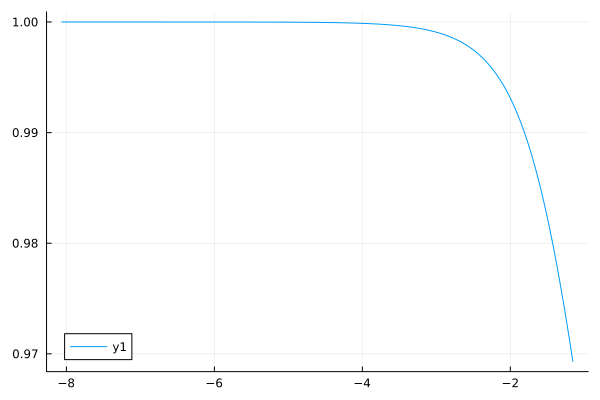

In [12]:
plt = FEM.HHTaccuracyAnalysis(Tₘᵢₙ, Tₘᵢₙ / π * (√(1 + sum(ξ)^2) - sum(ξ)), "SR", n=1000, α=α, δ=δ)

plot(plt)

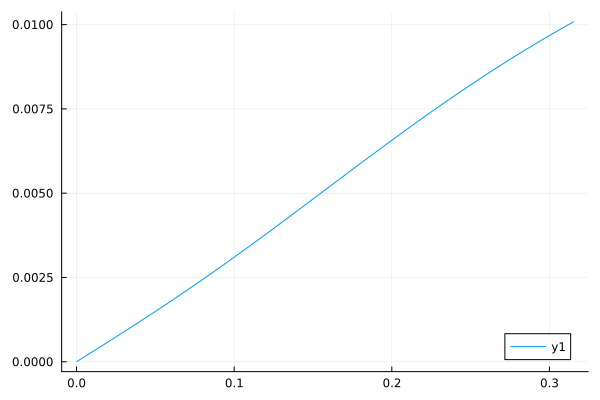

In [13]:
plt = FEM.HHTaccuracyAnalysis(Tₘᵢₙ, Tₘᵢₙ / π * (√(1 + sum(ξ)^2) - sum(ξ)), "ADR", n=1000, α=α, δ=δ)

plot(plt)

In [14]:
C1 = FEM.dampingMatrix(M, K, 2π / Tₘᵢₙ, ξ=ξ[1])
C2 = FEM.dampingMatrix(M, K, 2π / Tₘᵢₙ, ξ=ξ)
u2, v2, t2 = FEM.CDM(K, M, C1, f, u0, v0, 100Tₘᵢₙ, Tₘᵢₙ / π * (√(1 + ξ[1]^2) - ξ[1]))
u3, v3, t3 = FEM.CDM(K, M, C2, f, u0, v0, 100Tₘᵢₙ, Tₘᵢₙ / π * (√(1 + sum(ξ)^2) - sum(ξ)))

([0.0 0.0005868760880502221 … -1.3394991377849226e9 1.645020971458653e9; 0.0 0.00020476952876162958 … -2.7842756281210175e9 3.3449763348488636e9; … ; 0.0 0.08369874709115716 … 6.96772647355935e6 -8.308318973897903e6; 0.0 -4.6649484222834015e-20 … 1.1967058712132648e7 -1.4270119371036397e7], [0.0 7.011766704357587 … -2.89795097703745e13 3.565788273978707e13; 0.0 2.44650649953712 … -6.093024248253731e13 7.32299129435528e13; … ; 1000.0 1000.0 … 1.5306220336554208e11 -1.8251223558722998e11; 0.0 -5.573498510321498e-16 … 2.6288045513896347e11 -3.1347157508336255e11], [0.0, 8.369874709115715e-5, 0.0001673974941823143, 0.00025109624127347144, 0.0003347949883646286, 0.00041849373545578577, 0.0005021924825469429, 0.0005858912296381, 0.0006695899767292572, 0.0007532887238204144  …  0.025611816609893936, 0.025695515356985093, 0.02577921410407625, 0.025862912851167406, 0.025946611598258562, 0.02603031034534972, 0.026114009092440875, 0.02619770783953203, 0.026281406586623188, 0.026365105333714344])

In [15]:
plt1 = FEM.CDMaccuracyAnalysis(Tₘᵢₙ / √(1 - ξₘₐₓ^2)^1, Tₘᵢₙ / π * (√(1 + 1.5ξₘₐₓ^2) - 1.5ξₘₐₓ)^1, "SR", n=1000, ξₘₐₓ=ξₘₐₓ)
plt2 = FEM.RayleighDampingAccuracyAnalysis(Tₘᵢₙ, Tₘᵢₙ / π, "spectralRadius", n=100, ξₘₐₓ=ξₘₐₓ)

plot(plt, shape=:auto)

UndefVarError: UndefVarError: `RayleighDampingAccuracyAnalysis` not defined

In [16]:
O = spzeros(dof, dof)
A = [I O
    O -M]
B = [O I
    K C1]
λ, ϕ = Arpack.eigs(A, B, nev=2dof)

┌ Warning: Adjusting nev from 1212 to 1210
└ @ Arpack /home/perebal/.julia/packages/Arpack/FCvNd/src/Arpack.jl:92


(ComplexF64[-18275.36951960865 + 0.0im, 18275.369516732648 + 0.0im, 14823.694838024781 + 0.0im, -14823.694837342851 + 0.0im, -11136.716395684627 + 0.0im, 11136.716394209787 + 0.0im, -2.0389105763159512e-7 + 0.0649218166301566im, -2.0389105763159512e-7 - 0.0649218166301566im, -2.138692258989387e-7 + 0.023626370122290286im, -2.138692258989387e-7 - 0.023626370122290286im  …  3.0200327273325804e-7 + 4.1675114529210656e-5im, 3.0200327273325804e-7 - 4.1675114529210656e-5im, -2.099447273222608e-7 + 4.139935086024739e-5im, -2.099447273222608e-7 - 4.139935086024739e-5im, -2.0991135879071786e-7 + 4.1330841892566416e-5im, -2.0991135879071786e-7 - 4.1330841892566416e-5im, -2.0988321100844365e-7 + 4.1080662661126594e-5im, -2.0988321100844365e-7 - 4.1080662661126594e-5im, -2.0984058433680413e-7 + 3.97332633071956e-5im, -2.0984058433680413e-7 - 3.97332633071956e-5im], ComplexF64[-0.016103289874934167 + 0.0im -0.016103289872802653 + 0.0im … -2.922861126454469e-8 + 5.399794554786781e-6im -2.92286112645

In [17]:
λ


1210-element Vector{ComplexF64}:
     -18275.36951960865 + 0.0im
     18275.369516732648 + 0.0im
     14823.694838024781 + 0.0im
    -14823.694837342851 + 0.0im
    -11136.716395684627 + 0.0im
     11136.716394209787 + 0.0im
 -2.0389105763159512e-7 + 0.0649218166301566im
 -2.0389105763159512e-7 - 0.0649218166301566im
  -2.138692258989387e-7 + 0.023626370122290286im
  -2.138692258989387e-7 - 0.023626370122290286im
                        ⋮
  3.0200327273325804e-7 - 4.1675114529210656e-5im
  -2.099447273222608e-7 + 4.139935086024739e-5im
  -2.099447273222608e-7 - 4.139935086024739e-5im
 -2.0991135879071786e-7 + 4.1330841892566416e-5im
 -2.0991135879071786e-7 - 4.1330841892566416e-5im
 -2.0988321100844365e-7 + 4.1080662661126594e-5im
 -2.0988321100844365e-7 - 4.1080662661126594e-5im
 -2.0984058433680413e-7 + 3.97332633071956e-5im
 -2.0984058433680413e-7 - 3.97332633071956e-5im

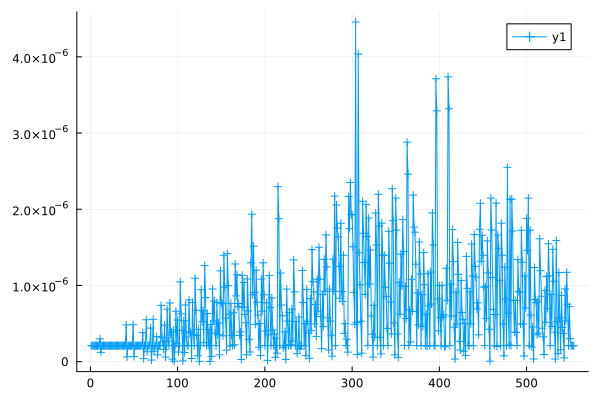

In [18]:
α = real.(λ[3:1:2dof-2])
β = imag.(λ[3:1:2dof-2])
ω = .√(α .^ 2 + β .^ 2)
ξ = α ./ ω
plot(abs.(α[101:2:2dof-4]), shape=:auto)

β = [8.39502161563975e-6, 1.4791270000996746e-14]


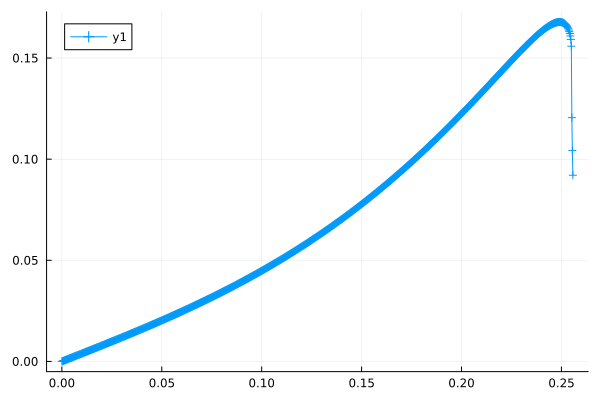

In [31]:
plt = FEM.CDMaccuracyAnalysis(1.0, 2π / Tₘᵢₙ, Tₘᵢₙ / π * (√(1 + (0.2)^2) - 0.2) * 0.98, "ADR", n=1000, ξ=[0.1, 0.1], show_β=true)

plot(plt, shape=:auto)
#plot!(plt[1], ξₘₐₓ / last(plt[1]) * plt[1])
#plot!(plt[1], ξₘₐₓ / last(plt[1]) * plt[1] + ξₘₐₓ / 2 / last(plt[1])^3 * plt[1] .^ 3)

In [20]:
S1 = FEM.solveStress(problem, u1)

LowLevelFEM.StressField([[0.0 -1.6632527862904957e-17 … -0.0002847623400493963 -0.00025831126392643436; 0.0 0.0 … -9.44307361604702e-6 1.0961017913484299e-5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 4.456758101797202e-17 … -0.0004353577278472783 -0.000600055576363604; 0.0 0.0 … -0.00014722408014204816 -0.0003126321253050106; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.461969728634603e-17 … -0.0009095850512307935 -0.0008512888078724668; 0.0 2.1350442781253005e-17 … 3.6590817349071766e-5 0.00016080042142673477; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 -1.7099641497712864e-18 … -0.0010292260698184688 -0.0011446922252313775; 0.0 -2.1350442781253005e-17 … -9.4515694383491e-5 -0.00019302161594061734; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 3.9796576251450075e-19 … -0.0016944957268407311 -0.0017609236111984067; 0.0 1.6012832085939753e-17 … -3.256863847466407e-5 -1.7221456780283422e-6; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 4.944065050765144e-19 … -0.001660

In [21]:
S2 = FEM.solveStress(problem, u2)

LowLevelFEM.StressField([[0.0 1.972892484059669e-21 … 1.2775562502672346 -1.4375366570989694; 0.0 0.0 … 0.2770535076892066 -0.3112811517173719; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.9796332747744862e-21 … -0.5448370711515056 0.6087749620857924; 0.0 0.0 … 0.16755667658342546 -0.19073539489510852; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 2.450583642177474e-21 … 0.2714948279101117 -0.3104877906639011; 0.0 0.0 … 0.002416928313467591 -0.0016371424297563387; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 2.7575962015157328e-24 … -0.4529831640712736 0.5027090698738279; 0.0 0.0 … -0.1620046211823191 0.18072623940984842; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 2.448990364372154e-21 … 0.3273130858904826 -0.37864318819425563; 0.0 0.0 … 0.052579079448658354 -0.05902025913224442; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.1030384806062936e-24 … -0.31395899751207307 0.34401183425833687; 0.0 0.0 … -0.046383312119423044 0.05120344207952051; … ; 0.0 0.0 … 0.0 0.0; 0.0

In [22]:
S3 = FEM.solveStress(problem, u3)

LowLevelFEM.StressField([[0.0 1.6324379004172626e-20 … -1.765943134747075e7 2.1057404874323454e7; 0.0 0.0 … -3.825508523694076e6 4.561698705545101e6; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 -8.518359623151983e-21 … 7.4975444666221e6 -8.941458303206787e6; 0.0 0.0 … -2.3205320981320133e6 2.767181519610841e6; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 7.798876436830393e-21 … -3.778802109018705e6 4.506803654417041e6; 0.0 0.0 … -29323.725020417096 34943.7825562899; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 4.884949014688554e-21 … 6.222595335793405e6 -7.419508594538417e6; 0.0 0.0 … 2.230406805322865e6 -2.659676902344272e6; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 -1.877681969816368e-20 … -4.585879028974072e6 5.467904047929161e6; 0.0 0.0 … -724376.0080939288 863805.115843524; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 7.252227188878147e-21 … 4.274151746488872e6 -5.097398928655118e6; 0.0 0.0 … 634395.7899680027 -756496.8658530747; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 …

In [23]:
sx1 = FEM.showStressResults(problem, S1, "sx", name="σx1(t)", t=t1, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


1

In [24]:
sx2 = FEM.showStressResults(problem, S2, "sx", name="σx2(t)", t=t2, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


2

In [25]:
sx3 = FEM.showStressResults(problem, S3, "sx", name="σx3(t)", t=t3, visible=false, smooth=true)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


3

In [26]:
ph1 = FEM.plotOnPath(problem, "path", sx1, 500, visible=false)

4

In [27]:
ph2 = FEM.plotOnPath(problem, "path", sx2, 500, visible=true)

5

In [28]:
ph3 = FEM.plotOnPath(problem, "path", sx3, 500, visible=true)

6

In [29]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.12.2
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.6.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XOpenIM() failed
XRequest.18: BadValue 0x0


In [30]:
gmsh.finalize()